In [1]:
import yfinance as yf
df = yf.download("AAPL", start="2000-01-01", end="2021-01-01")
print(df)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1999-12-31    0.901228    0.918527    0.888393    0.917969    0.783791   
2000-01-03    0.936384    1.004464    0.907924    0.999442    0.853355   
2000-01-04    0.966518    0.987723    0.903460    0.915179    0.781409   
2000-01-05    0.926339    0.987165    0.919643    0.928571    0.792844   
2000-01-06    0.947545    0.955357    0.848214    0.848214    0.724232   
...                ...         ...         ...         ...         ...   
2020-12-24  131.320007  133.460007  131.100006  131.970001  130.620895   
2020-12-28  133.990005  137.339996  133.509995  136.690002  135.292679   
2020-12-29  138.050003  138.789993  134.339996  134.869995  133.491257   
2020-12-30  135.580002  135.990005  133.399994  133.720001  132.353027   
2020-12-31  134.080002  134.740005  131.720

c:\Users\14ZD\miniconda3\envs\Pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


100%|██████████| 50/50 [02:12<00:00,  2.65s/it]


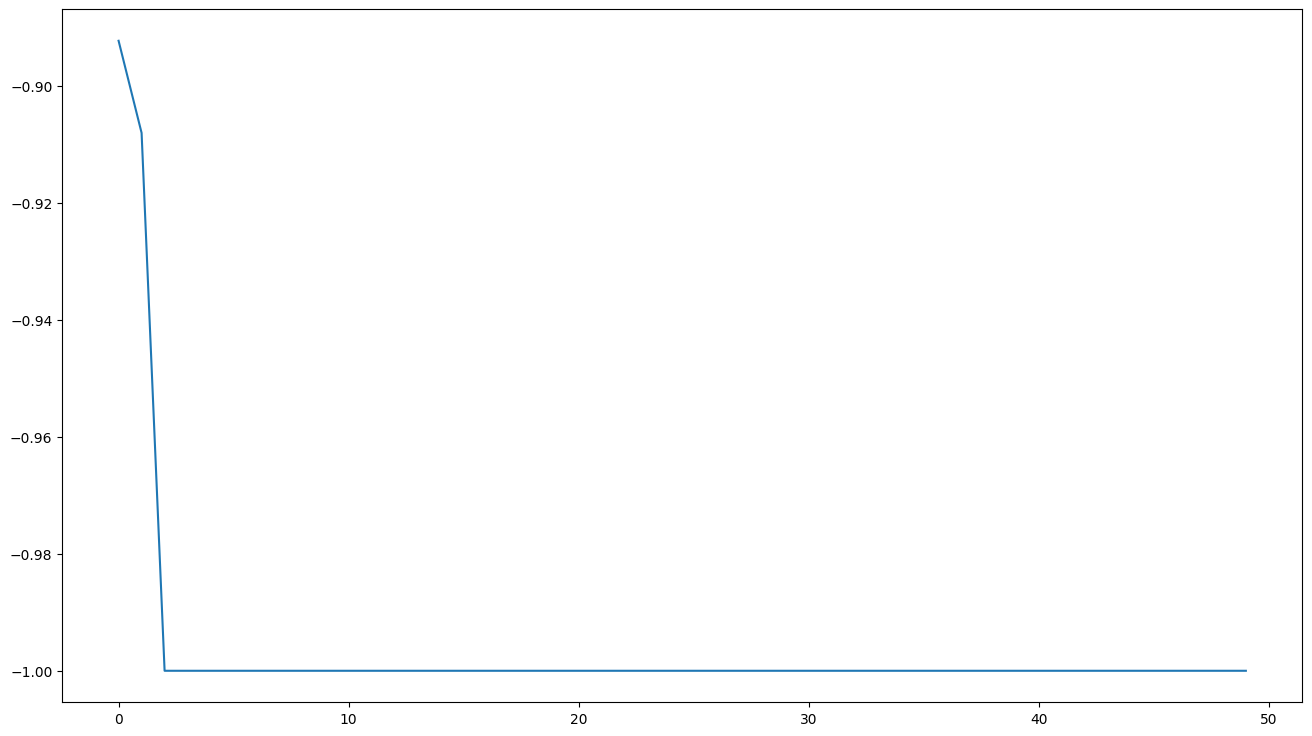

In [1]:
import pandas as pd
import copy
import syntheticChrissAlmgren2 as sca
import utils
import numpy as np
import yfinance as yf
import time
import sys
import matplotlib.pyplot as plt
import torch
import math
from tqdm import tqdm
from datetime import date, timedelta
from ddpg_agent import Agent
from collections import deque


class AC_RL_model():
    def __init__(self, ep, train_coverage, ticker, TOTAL_SHARES, NUM_TRADES, LIQUIDATION_TIME, start_date, end_date, ANNUAL_VOLAT,
                 BID_ASK_SP, llambda_list):

        self.TOTAL_SHARES = TOTAL_SHARES
        self.NUM_TRADES = NUM_TRADES
        self.LIQUIDATION_TIME = LIQUIDATION_TIME
        self.start_date = start_date
        self.end_date = end_date
        self.ticker = ticker
        self.num_ticker = len(ticker)
        self.data_origin = yf.download(ticker[0], start=start_date, end=end_date)
        self.TRAD_DAYS = len(self.data_origin['Open'])
        self.today = None
        self.date_list = []
        self.episode = 0

        self.subtract_days = timedelta(NUM_TRADES)
        self.slidingwindow_num = self.TRAD_DAYS - NUM_TRADES + 1
        self.randomseed = 0
        self.BID_ASK_SP = BID_ASK_SP
        self.tau = 1
        self.DAILY_VOLAT = ANNUAL_VOLAT / np.sqrt(self.TRAD_DAYS)
        self.llambda_list = llambda_list
        self.ep = ep
        self.num_train = train_coverage
        self.agent = None
        self.loss_list = []
        self.loss_df = None
        self.save_model_path = f'C:/Users/14ZD/Desktop/2022_Summer_LabIntern/Almgren and Chriss Model/models/{str(self.ep)+"epoches_"+str(self.num_train)+"daysTrain_"+str(self.TOTAL_SHARES)+"shares_"+str(self.LIQUIDATION_TIME)+"days"}.pt'


    def extract_dataFrame(self, stock):
        data_total = yf.download(stock, start=start_date - timedelta(self.num_train*2), end=end_date)
        data_train = data_total.tail(self.num_train+self.TRAD_DAYS).head(self.num_train)
        data_test = data_total.tail(self.num_train+self.TRAD_DAYS)
        data_trade = data_total.tail(self.TRAD_DAYS)
        
        return data_total, data_train, data_trade, data_test

    def twap(self,data_trade, idx):
        starting_price = data_trade.iloc[idx]['Close']
        #print(data_trade.iloc[idx:self.LIQUIDATION_TIME+idx])
        high_list = data_trade.iloc[idx:self.LIQUIDATION_TIME+idx]['High']
        #print("high:", high_list)
        low_list = data_trade.iloc[idx:self.LIQUIDATION_TIME+idx]['Low']
        #print("low:", low_list)
        mid_price_list = [int((high+low)/2) for high,low in zip(high_list,low_list)]
        trade_shares = self.TOTAL_SHARES // self.LIQUIDATION_TIME
        remaining_shares = self.TOTAL_SHARES % self.LIQUIDATION_TIME
        trade_list = []
        for num in range(self.LIQUIDATION_TIME):
            if num ==0:
                trade_list.append(trade_shares+remaining_shares)
            else:
                trade_list.append(trade_shares)
        capture = [price*share for price, share in zip(mid_price_list, trade_list)]
        shortfall = self.TOTAL_SHARES*starting_price - sum(capture)
        #print("Starting Price from TWAP:",starting_price)
        #print("TWAP Trade List:", trade_list)
        #print("TWAP Price List:", mid_price_list)
        #print("TWAP Capture:", sum(capture))

        assert sum(trade_list) == self.TOTAL_SHARES

        return int(shortfall)

    def ac_optimal(self,data_calibration, data_trade, idx):

            # Financial Parameters Calibration Using Past Stock Data
            average_daily_volume = np.mean(data_calibration['Volume'])
            average_daily_spread = np.mean(data_calibration['High'] - data_calibration['Low'])
            epsilon = average_daily_spread / 2
            eta = average_daily_spread / (0.01 * average_daily_volume)
            gamma = average_daily_spread / (0.1 * average_daily_volume)
            llambda = self.llambda_list[0]

            startingPrice = data_trade.head(1 + idx)['Close'][-1]
            self.today = data_trade.index[idx]
            self.date_list.append(self.today)
            singleStepVariance = (self.DAILY_VOLAT * startingPrice) ** 2

            # AC Environment Initialized with new financial parameters
            env = sca.MarketEnvironment()
            env.__init__(0, self.LIQUIDATION_TIME, self.NUM_TRADES,
                            llambda, startingPrice, epsilon,
                            eta, gamma,
                            self.TOTAL_SHARES, singleStepVariance)

            trl = env.get_trade_list()
            trade_list = utils.round_trade_list(trl)
            #print("AC Trade List:", trade_list)
            env.start_transactions()
            price_hist = np.array([])
            action_list = []
            int_list = []
            for trade in trade_list:
                int_list.append(int(trade))

            #print(int_list)
            assert sum(int_list) == self.TOTAL_SHARES

            for trade in int_list:
                action = trade / env.shares_remaining
                #print(env.shares_remaining)
                _, _, _, info = env.step(action)
                action_list.append(action)
                price_hist = np.append(price_hist, info.exec_price)
                if info.done:
                    shortfall = info.implementation_shortfall
                    
                # If all shares have been sold, stop making transactions and get the implementation shortfall
                if info.done:
                    # print('Implementation Shortfall: ${:,.2f} \n'.format(info.implementation_shortfall))
                    break
            
            #print("AC Trade List:", action_list)
            return int(shortfall)      

    def rl_optimal(self, data_calibration, data_trade, data_test, idx):
        
        # Financial Parameters Calibration Using Past Stock Data
        average_daily_volume = np.mean(data_calibration['Volume'])
        average_daily_spread = np.mean(data_calibration['High'] - data_calibration['Low'])
        epsilon = average_daily_spread / 2
        eta = average_daily_spread / (0.01 * average_daily_volume)
        gamma = average_daily_spread / (0.1 * average_daily_volume)
        llambda = self.llambda_list[0]
        #print(data_trade.head(1+idx))
        startingPrice = data_trade.head(1 + idx)['Close'][-1]
        singleStepVariance = (self.DAILY_VOLAT * startingPrice) ** 2

        rl_env = sca.MarketEnvironment()
        rl_env.__init__(0, self.LIQUIDATION_TIME, self.NUM_TRADES,
                        llambda, startingPrice, epsilon, 
                        eta, gamma, 
                        self.TOTAL_SHARES, singleStepVariance)

        rl_trl = rl_env.get_trade_list()
        rl_trade_list = utils.round_trade_list(rl_trl)

        model = torch.load(self.save_model_path)

        agent = Agent(state_size=rl_env.observation_space_dimension(), action_size=rl_env.action_space_dimension(), 
                        random_seed=0)
        agent.actor_local.load_state_dict(model)

        cnt = 0 
        data_log_return = data_test.iloc[-self.TRAD_DAYS-7+idx+cnt:-self.TRAD_DAYS+idx+cnt]
        logReturn_list = data_log_return['Close']
        logReturn = list(np.log((logReturn_list / logReturn_list.shift(1))).tail(6))
        cur_state = np.array(logReturn + [rl_env.timeHorizon / rl_env.num_n, rl_env.shares_remaining / rl_env.total_shares])


        rl_env.start_transactions()
        rl_action_list = []

        for trade in rl_trade_list:

            rl_action = agent.act(cur_state, add_noise = True)
            #print(rl_env.shares_remaining)
            new_state, rl_reward, done, rl_info = rl_env.step(rl_action)
            rl_action_list.append(rl_action[0])

            # env.step 할때마다 state가 바뀌므로 logReturn에 대한 업데이트 필요
            cnt += 1
            data_log_return = data_test.iloc[-self.TRAD_DAYS-7+idx+cnt:-self.TRAD_DAYS+idx+cnt]
            logReturn_list = data_log_return['Close']
            logReturn = list(np.log((logReturn_list / logReturn_list.shift(1))).tail(6))
            new_state = np.array(logReturn + [rl_env.timeHorizon / rl_env.num_n, rl_env.shares_remaining / rl_env.total_shares])
            cur_state = new_state

            if rl_info.done:
                rl_shortfall = rl_info.implementation_shortfall
                break
        #print("RL Trade List:", rl_action_list)
        
        return int(rl_shortfall)
    
    def run_RL(self, data_total, data_train):

        end = -abs(self.num_train)
        mean_reward_per_day = []
        for day in range(self.num_train):
            # 데이터 사용은 그 전날까지, 즉 logReturn 의 k번째도 전날이여야함, k-1 = 전전날
            # Parameters Calibration is determined by past data with length of train coverage
            data_calibration = data_total.iloc[day:self.num_train + day]

            # Financial Parameters Calibration Using Past Stock Data
            average_daily_volume = np.mean(data_calibration['Volume'])
            average_daily_spread = np.mean(data_calibration['High'] - data_calibration['Low'])
            epsilon = average_daily_spread / 2
            eta = average_daily_spread / (0.01 * average_daily_volume)
            gamma = average_daily_spread / (0.1 * average_daily_volume)
            llambda = self.llambda_list[0]

            startingPrice = data_train.head(1 + day)['Close'][0]
            self.today = data_train.index[day]
            singleStepVariance = (self.DAILY_VOLAT * startingPrice) ** 2


            # Create RL Environment
            rl_env = sca.MarketEnvironment()
            rl_env.__init__(0, self.LIQUIDATION_TIME, self.NUM_TRADES,
                            llambda, startingPrice, epsilon,
                            eta, gamma,
                            self.TOTAL_SHARES, singleStepVariance)

            rl_shortfall_hist = np.array([])
            rl_shortfall_deque = deque(maxlen=100)

            # Reset RL Environment in every episode
            assert self.LIQUIDATION_TIME >= 6
            cnt_log = 0
            data_log_return = data_total.iloc[end - self.TRAD_DAYS - 7 + cnt_log:end - self.TRAD_DAYS + cnt_log]
            logReturn_list = data_log_return['Close']
            logReturn = list(np.log((logReturn_list / logReturn_list.shift(1))).tail(6))

            rl_trl = rl_env.get_trade_list()
            rl_trade_list = utils.round_trade_list(rl_trl)
            cur_state = np.array(logReturn + [rl_env.timeHorizon / rl_env.num_n, rl_env.shares_remaining / rl_env.total_shares])

            rl_env.start_transactions()
            rl_action_list = []
            reward_list = []

            for trade in rl_trade_list:
                # RL Total Capture Learning
                rl_action = self.agent.act(cur_state, add_noise=True)
                rl_action_list.append(rl_action[0])

                #negative reward can be loss in RL
                new_state, rl_reward, done, rl_info = rl_env.step(rl_action)
                reward_list.append(rl_reward[0])
                
                # env.step 할때마다 state가 바뀌므로 logReturn에 대한 업데이트 필요
                cnt_log += 1
                data_log_return = data_total.iloc[end - self.TRAD_DAYS - 7 + cnt_log:end - self.TRAD_DAYS + cnt_log]
                logReturn_list = data_log_return['Close']
                logReturn = list(np.log((logReturn_list / logReturn_list.shift(1))).tail(6))

                new_state = np.array(logReturn + [rl_env.timeHorizon / rl_env.num_n,
                                                    rl_env.shares_remaining / rl_env.total_shares])

                self.agent.step(cur_state, rl_action, rl_reward, new_state, done)

                cur_state = new_state

                if rl_info.done:
                    #print(rl_info.implementation_shortfall)
                    rl_shortfall_hist = np.append(rl_shortfall_hist, int(rl_info.implementation_shortfall))
                    rl_shortfall_deque.append(int(rl_info.implementation_shortfall))
                    mean_reward_per_day.append(np.mean(reward_list))
                    break

            # if (self.episode + 1) % 100 == 0:
            #     print('\r{},{}, Episode [{}/{}]\Total Shortfall: ${:,.2f}'.format(self.ticker[stock_num], self.today, self.episode + 1,
            #                                                                         self.ep,
            #                                                                         np.mean(rl_shortfall_deque)))

            self.episode += 1
            end += 1

        return -abs(np.mean(mean_reward_per_day))
    
    def train(self):
        self.episode = 0
        self.agent = Agent(state_size=8,action_size=1,random_seed=0)
        stock = {}
        for idx in range(len(self.ticker)):
            data_total, data_train, data_trade, data_test = self.extract_dataFrame(self.ticker[idx])
            stock[str(idx)+"_data_total"] = data_total
            stock[str(idx)+"_data_train"] = data_train
            stock[str(idx)+"_data_trade"] = data_trade
            stock[str(idx)+"_data_test"] = data_test

        for episode in tqdm(range(self.ep)):
            loss_train = []
            for stock_num in range(len(self.ticker)):
                stock_loss = self.run_RL(stock[str(stock_num)+"_data_total"], stock[str(stock_num)+"_data_train"])
                loss_train.append(stock_loss)
            self.loss_list.append(np.mean(loss_train))
            #print(self.loss_list)
            # if episode == 4:
            #     print(self.loss_list)
            #     sys.exit()

        torch.save(self.agent.actor_local.state_dict(), self.save_model_path)
        self.loss_df = pd.DataFrame({"Train":self.loss_list})
        plt.plot(self.loss_df)
        
    
    def test(self):
        for code in self.ticker:
                
            data_total, data_train, data_trade, data_test = self.extract_dataFrame(code)
            #print(code, data_trade)
            ac_shortfall_list = []
            twap_shortfall_list = []
            rl_shortfall_list = []
            self.date_list = []
            for idx in range(self.slidingwindow_num):
                #AIS = averaged implementation shortfall
                data_calibration = data_test.iloc[idx:self.num_train + idx]
                ac_shortfall = self.ac_optimal(data_calibration, data_trade, idx)
                ac_shortfall_list = np.append(ac_shortfall_list, round(ac_shortfall/self.TOTAL_SHARES,4))
                twap_shortfall = self.twap(data_trade, idx)
                twap_shortfall_list = np.append(twap_shortfall_list, round(twap_shortfall/self.TOTAL_SHARES,4))
                rl_shortfall = self.rl_optimal(data_calibration, data_trade, data_test, idx)
                rl_shortfall_list = np.append(rl_shortfall_list, round(rl_shortfall/self.TOTAL_SHARES,4))

                # print()
                # print(twap_shortfall_list)
                # print(ac_shortfall_list)
                # print(rl_shortfall_list)
                # print()
                # print("ㅡ"*50)
                # if idx ==2:    
                #     sys.exit()

            assert len(ac_shortfall_list) == len(twap_shortfall_list) and len(twap_shortfall_list) == len(rl_shortfall_list) and len(rl_shortfall_list) == len(self.date_list)

            # print(len(ac_shortfall_list))
            # print(len(twap_shortfall_list))
            # print(len(rl_shortfall_list))
            # print(len(self.date_list))

            result = [ac_shortfall_list > rl_shortfall_list]
            df = pd.DataFrame({'TWAP': twap_shortfall_list, 'AC':ac_shortfall_list, 'RL':rl_shortfall_list}, index=self.date_list)
            
            if code == self.ticker[-1]:
                print()
                print('='*70)
                print(code)
                print(df)
                print('='*70)
                print()


            # print(result)
            # sys.exit()



TOTAL_SHARES = 1000000
NUM_TRADES = 6
LIQUIDATION_TIME = 6
start_date = date(2022, 1, 3)
end_date = '2022-02-01'
ticker = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

#Hyperparameter
ANNUAL_VOLAT = 0.12
BID_ASK_SP = 1 / 8
llambda_list = [1e-06]

train_coverage = 50
eps = [50]

for ep in eps:
    simulation = AC_RL_model(ep, train_coverage, ticker, TOTAL_SHARES, NUM_TRADES, LIQUIDATION_TIME, start_date, end_date, ANNUAL_VOLAT,
                                BID_ASK_SP, llambda_list)
    plt.rcParams['figure.figsize'] = [16.0, 9.0]                            
    simulation.train()
    #simulation.test()

# simulation = AC_RL_model(ep, train_coverage, ticker, 10000, 10, 10, start_date, end_date, ANNUAL_VOLAT,
#                             BID_ASK_SP, llambda_list)
# plt.rcParams['figure.figsize'] = [16.0, 9.0]                            
# #simulation.train()
# simulation.test()





In [1]:
a = [6,7,8]
b = [1,2,3]
print(a-b)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\14ZD\miniconda3\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode [100/4000]\Total Capture: $89,198,168.37
Episode [200/4000]\Total Capture: $86,531,578.00
Episode [300/4000]\Total Capture: $86,531,578.00
Episode [400/4000]\Total Capture: $86,531,578.00
Episode [500/4000]\Total Capture: $86,531,578.00
Episode [600/4000]\Total Capture: $86,531,578.00
Episode [700/4000]\Total Capture: $86,531,578.00
Episode [800/4000]\Total Capture: $86,531,578.00
Episode [900/4000]\Total Capture: $86,531,578.00
Episode [1000/4000]\Total Capture: $86,531,578.00
Episode [1100/4000]\Total Capture: $86,531,578.00
Episode [1200/4000]\Total Capture: $86,531,578.00
Episode [1300/4000]\Total Capture: $86,531,578.00
Episode [1400/4000]\Total Capture: $86,531,578.00
Episode [1500/4000]\Total Capture: $86,531,578.00
Episode [1600/4000]\Total Capture: $86,531,578.00
Episode [1700/4000]\Total Capture: $86,531,578.00
Episode [1800/4000]\Total Capture: $86,531,578.00
Episode [1900/4000]\Total Capture: $86,531,578.00
Episode [2000/4000]\Total Capture: $86,531,578.00
Episode [

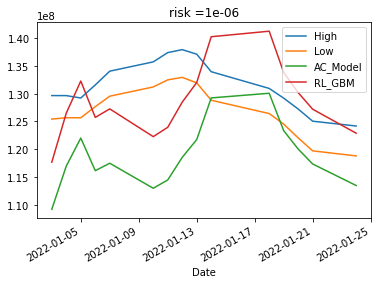

In [2]:
import pandas as pd
import copy
import syntheticChrissAlmgren2 as sca
import utils
import numpy as np
import yfinance as yf
import time
import sys
import matplotlib.pyplot as plt
from datetime import date, timedelta
from ddpg_agent import Agent
from collections import deque



class AC_model():
    def __init__(self, TOTAL_SHARES, NUM_TRADES, LIQUIDATION_TIME, start_date, end_date, ticker, ANNUAL_VOLAT, BID_ASK_SP, llambda_list):
        
        self.TOTAL_SHARES = TOTAL_SHARES
        self.NUM_TRADES = NUM_TRADES
        self.LIQUIDATION_TIME = LIQUIDATION_TIME
        self.start_date = start_date
        self.end_date = end_date
        self.ticker = ticker

        self.subtract_days = timedelta(NUM_TRADES)
        self.num_shares, self.last_num_shares = self.round_num_shares(self.TOTAL_SHARES, self.NUM_TRADES)
        self.data_origin =yf.download(ticker, start=start_date, end=end_date)
        self.TRAD_DAYS = len(self.data_origin['Open'])
        self.slidingwindow_num = self.TRAD_DAYS - NUM_TRADES + 1
        self.randomseed = 0                                
        self.BID_ASK_SP = BID_ASK_SP
        self.tau = 1
        self.DAILY_VOLAT = ANNUAL_VOLAT / np.sqrt(self.TRAD_DAYS)
        self.index_list = self.data_origin.index[:]
        self.llambda_list= llambda_list
        
        #DataFrame for Total Capture of "High" Price Execution and "Low" Price Execution
        self.df = yf.download(ticker, start = start_date-timedelta(self.TRAD_DAYS), end = end_date)
        
        self.df_trad = self.df.tail(self.TRAD_DAYS)
        self.total_cash_list, self.date_list = self.calculate_revenue(self.df_trad, 'High', self.slidingwindow_num, 
                                                       self.NUM_TRADES, self.num_shares, self.last_num_shares)
        self.frame1 = pd.DataFrame({"Date": self.date_list, "High": self.total_cash_list})

        self.total_cash_list2, self.date_list2 = self.calculate_revenue(self.df_trad, 'Low', self.slidingwindow_num, 
                                                       self.NUM_TRADES, self.num_shares, self.last_num_shares)
        self.frame2 = pd.DataFrame({"Date": self.date_list2, "Low": self.total_cash_list2})

    
    #TWAP method for determining number of shares to trade each day
    def round_num_shares(self, total_shares, num_trades):
        num_shares = total_shares // num_trades + 1
        last_num_shares = num_shares
        if type(total_shares / num_trades) != int:
            last_num_shares = total_shares - (num_shares*(num_trades-1))

        return num_shares, last_num_shares

    
    #Calculation of Total Capture of "High", "Low" Price Execution
    def calculate_revenue(self, df, category, slidingwindow_num, NUM_TRADES, num_shares, last_num_shares):
        total_cash_list = []
        date_list = []
        for window_num in range(slidingwindow_num):
            total_cash = 0
            for idx in range(NUM_TRADES):
                price = df[category][window_num:window_num+NUM_TRADES][idx]
                if idx == NUM_TRADES:
                    daily_cash = price * last_num_shares
                else:
                    daily_cash = price * num_shares
                total_cash += daily_cash
            total_cash_list.append(int(total_cash))
            date_list.append(df[category].index[window_num])

        return total_cash_list, date_list
    
    
    #Simulation to identify if AC Model fits between "High" and "Low" Price Execution Band
    def simulate_ac_model(self, episodes):
        for risk in self.llambda_list:
            llambda = risk
            
            #Previous Stock Data with length of Liquidation Time is used for parameter calibration
            start = -abs(self.TRAD_DAYS+self.LIQUIDATION_TIME)
            end = -abs(self.TRAD_DAYS)
            ac_date_list =[]
            Actual_Revenue_List = []
            capture_list = []
            rl_capture_list =[]
            cnt = 0

            for idx in range(self.slidingwindow_num):

                #데이터 사용은 그 전날까지, 즉 logReturn 의 k번째도 전날이여야함, k-1 = 전전날
                #data for trading list extraction AC model, not necessary for RL model
                data = self.df.iloc[start:end]

                if end+NUM_TRADES != 0:
                    data_real_price = self.data_origin.iloc[end:end+self.NUM_TRADES]['Open'].to_numpy()
                else:
                    data_real_price = self.data_origin.iloc[end:]['Open'].to_numpy()

                #오늘은 1일 (월 첫날) k+1로 가정
                today = self.data_origin.index[cnt]
                today = self.df.index[end]

                ac_date_list.append(today)

                #Financial Parameters Calibration Using Past Stock Data
                average_daily_volume = np.mean(data['Volume'])
                average_daily_spread = np.mean(data['High'] - data['Low'])
                epsilon = average_daily_spread/2
                eta = average_daily_spread/(0.01*average_daily_volume)
                gamma = average_daily_spread/(0.1*average_daily_volume)

                startingPrice = data.tail(1)['Close'][0]
                singleStepVariance = (self.DAILY_VOLAT  * startingPrice) ** 2

                #AC Environment Initialized with new financial parameters
                env = sca.MarketEnvironment()
                env.__init__(0, self.LIQUIDATION_TIME, self.NUM_TRADES,
                             llambda, startingPrice, epsilon, 
                             eta, gamma, 
                             self.TOTAL_SHARES, singleStepVariance)

                # Get the trading list from the environment
                trl = env.get_trade_list()

                # Since we are not selling fractional shares we round up the shares in the trading list
                trade_list = utils.round_trade_list(trl)

                # Implement the trading list in our similation environment            
                env.start_transactions()      
                price_hist = np.array([])

                for trade in trade_list:
                    # Normal AC Total Capture Calculation
                    # Convert the number of shares to sell in each trade into an action
                    action = trade / env.shares_remaining

                    # Take a step in the environment my selling the number of shares in the current trade
                    _, _, _, info = env.step(action)

                    # Get the impacted price from the environment
                    price_hist = np.append(price_hist, info.exec_price)
                    if info.done:
                        capture = info.totalCapture

                    # If all shares have been sold, stop making transactions and get the implementation shortfall
                    if info.done:
                        #print('Implementation Shortfall: ${:,.2f} \n'.format(info.implementation_shortfall))
                        break


                final_trade_list = np.trim_zeros(trade_list.astype(int))
                capture_list.append(int(capture))

                #print("AC Capture:", capture)

                if len(final_trade_list) != len(data_real_price):
                    length = len(final_trade_list)
                    modified_data_real_price = data_real_price[:length]
                else:
                    modified_data_real_price = data_real_price

                Actual_Revenue_append = int(np.sum(final_trade_list*modified_data_real_price))
                Actual_Revenue_List.append(Actual_Revenue_append)


                #Create RL Environment
                rl_env = sca.MarketEnvironment()
                rl_env.__init__(0, self.LIQUIDATION_TIME, self.NUM_TRADES,
                             llambda, startingPrice, epsilon, 
                             eta, gamma, 
                             self.TOTAL_SHARES, singleStepVariance)

                rl_trl = rl_env.get_trade_list()
                rl_trade_list = utils.round_trade_list(trl)


                agent = Agent(state_size=rl_env.observation_space_dimension(), action_size=rl_env.action_space_dimension(), 
                              random_seed=0)

                rl_capture_hist = np.array([])
                rl_capture_deque = deque(maxlen=100)

                #Liquidation time 만큼 한칸씩 popleft되야되는 부분 수정 필요


                #Run Episodes for Reinforcement Learning
                for episode in range(episodes):

                    #Reset RL Environment in every episode
                    assert self.LIQUIDATION_TIME >=  6
                    cnt = 0 
                    data_log_return = self.df.iloc[end-7+cnt:end+cnt]
                    logReturn_list = data_log_return['Close']
                    logReturn = list(np.log((logReturn_list / logReturn_list.shift(1))).tail(6))

                    rl_env.__init__(0, self.LIQUIDATION_TIME, self.NUM_TRADES,
                             llambda, startingPrice, epsilon, 
                             eta, gamma, 
                             self.TOTAL_SHARES, singleStepVariance)

                    rl_trl = rl_env.get_trade_list()
                    rl_trade_list = utils.round_trade_list(trl)
                    cur_state = np.array(logReturn + [rl_env.timeHorizon / rl_env.num_n, \
                                                                           rl_env.shares_remaining / rl_env.total_shares])

                    rl_env.start_transactions()
                    rl_action_list = []

                    for trade in rl_trade_list:
                        #RL Total Capture Learning
                        rl_action = agent.act(cur_state, add_noise = True)
                        rl_action_list.append(rl_action[0])

                        new_state, rl_reward, done, rl_info = rl_env.step(rl_action)
                        # env.step 할때마다 state가 바뀌므로 logReturn에 대한 업데이트 필요

                        cnt += 1
                        if end + cnt == 0:
                            data_log_return = self.df.iloc[end-7+cnt:]
                        else:    
                            data_log_return = self.df.iloc[end-7+cnt:end+cnt]
                        logReturn_list = data_log_return['Close']
                        logReturn = list(np.log((logReturn_list / logReturn_list.shift(1))).tail(6))

                        new_state = np.array(logReturn + [rl_env.timeHorizon / rl_env.num_n, rl_env.shares_remaining / rl_env.total_shares])

                        agent.step(cur_state, rl_action, rl_reward, new_state, done)

                        cur_state = new_state

                        if rl_info.done:
                            rl_capture_hist = np.append(rl_capture_hist, int(rl_info.totalCapture))
                            rl_capture_deque.append(int(rl_info.totalCapture))
                            break


    #                     if episode == 0 or episode == 500 or episode == 2400 or episode + 1 == episodes:
    #                         print("RL trade list by percentage:", rl_action_list)


                    if idx == 0:
                        if (episode + 1) % 100 == 0:

                            print('\rEpisode [{}/{}]\Total Capture: ${:,.2f}'.format(episode + 1, episodes, np.mean(rl_capture_deque)))

                    if episode+1 ==  episodes:
                        #print(rl_trade_list)
                        print(today)
                        print('\rEpisode [{}/{}]\Total Capture: ${:,.2f}'.format(episode + 1, episodes, np.mean(rl_capture_deque)))


                #Append Extracted Total Capture of a specified liquidation start date        
                rl_capture_list = np.append(rl_capture_list, np.mean(rl_capture_deque))


                start += 1
                end += 1
                cnt += 1

                
                
#                 #GBM Price Chart with High, Low price band
#                 if llambda == 1e-10 and idx == 0:
#                     price_list_num = len(price_hist)
                    
#                     GBM_price_frame = pd.DataFrame({"Date":self.index_list[:price_list_num], "Price": price_hist})
#                     GBM_price_frame.set_index("Date", inplace = True)
#                     REAL_LOW_price_frame = self.data_origin['Low'].head(price_list_num)
                    
#                     REAL_HIGH_price_frame = self.data_origin['High'].head(price_list_num)
#                     realFrame = pd.merge(REAL_LOW_price_frame, REAL_HIGH_price_frame,left_index=True, right_index=True)
#                     finalFrame = pd.merge(realFrame,GBM_price_frame, left_index=True, right_index=True)
#                     finalFrame.plot()
                
    
#                 #Stopping on a first date to check the ability of RL method compared to normal AC optimization
#                 if idx == 0:
#                     break


            #Plot Total Capture Comparison Graph of slidingwindow    
            rlframe = pd.DataFrame({"Date": ac_date_list, "RL_GBM": rl_capture_list})
            ACframe = pd.DataFrame({"Date": ac_date_list, "AC_Model":capture_list})
            ARframe = pd.DataFrame({"Date": ac_date_list, "Actual_Revenue": Actual_Revenue_List})
            newframe = pd.merge(self.frame1, self.frame2, how='inner', on='Date').merge(ACframe, on = 'Date').merge(rlframe, on="Date")
            newframe.set_index("Date", inplace=True)

            plt.rcParams['figure.figsize'] = [17.0, 7.0]
            titleName = "risk =" + str(llambda)
            newframe.plot(title = titleName)
            print(newframe)


            
            

TOTAL_SHARES = 1000000
NUM_TRADES = 6
LIQUIDATION_TIME = 6
start_date = date(2022,1,3)
end_date = '2022-02-01'
ticker = 'TSM'
ANNUAL_VOLAT = 0.12                                
BID_ASK_SP = 1 / 8                                                                 
llambda_list= [1e-06]
plt.rcParams['figure.figsize'] = [17.0, 7.0]
EPISODES = 4000

simulation = AC_model(TOTAL_SHARES, NUM_TRADES, LIQUIDATION_TIME, start_date, end_date, ticker, ANNUAL_VOLAT, BID_ASK_SP, llambda_list)
#print(simulation.data_origin)
simulation.simulate_ac_model(EPISODES)



***Change Capture to IS and Create train model***

In [ ]:
import pandas as pd
import copy
import syntheticChrissAlmgren2 as sca
import utils
import numpy as np
import yfinance as yf
import time
import sys
import matplotlib.pyplot as plt
from datetime import date, timedelta
from ddpg_agent import Agent
from collections import deque



class AC_model_train():
    def __init__(self, TOTAL_SHARES, NUM_TRADES, LIQUIDATION_TIME, start_date, end_date, ticker, ANNUAL_VOLAT, BID_ASK_SP, llambda_list):
        
        self.TOTAL_SHARES = TOTAL_SHARES
        self.NUM_TRADES = NUM_TRADES
        self.LIQUIDATION_TIME = LIQUIDATION_TIME
        self.start_date = start_date
        self.end_date = end_date
        self.ticker = ticker

        self.subtract_days = timedelta(NUM_TRADES)
        self.num_shares, self.last_num_shares = self.round_num_shares(self.TOTAL_SHARES, self.NUM_TRADES)
        self.data_origin =yf.download(ticker, start=start_date, end=end_date)
        self.TRAD_DAYS = len(self.data_origin['Open'])
        self.slidingwindow_num = self.TRAD_DAYS - NUM_TRADES + 1
        self.randomseed = 0                                
        self.BID_ASK_SP = BID_ASK_SP
        self.tau = 1
        self.DAILY_VOLAT = ANNUAL_VOLAT / np.sqrt(self.TRAD_DAYS)
        self.index_list = self.data_origin.index[:]
        self.llambda_list= llambda_list
        
        #DataFrame for Total Capture of "High" Price Execution and "Low" Price Execution
        self.df = yf.download(ticker, start = start_date-timedelta(252), end = end_date)
        
        self.df_trad = self.df.tail(self.TRAD_DAYS)
        self.total_cash_list, self.date_list = self.calculate_revenue(self.df_trad, 'High', self.slidingwindow_num, 
                                                       self.NUM_TRADES, self.num_shares, self.last_num_shares)
        self.frame1 = pd.DataFrame({"Date": self.date_list, "High": self.total_cash_list})

        self.total_cash_list2, self.date_list2 = self.calculate_revenue(self.df_trad, 'Low', self.slidingwindow_num, 
                                                       self.NUM_TRADES, self.num_shares, self.last_num_shares)
        self.frame2 = pd.DataFrame({"Date": self.date_list2, "Low": self.total_cash_list2})

    
    #TWAP method for determining number of shares to trade each day
    def round_num_shares(self, total_shares, num_trades):
        num_shares = total_shares // num_trades + 1
        last_num_shares = num_shares
        if type(total_shares / num_trades) != int:
            last_num_shares = total_shares - (num_shares*(num_trades-1))

        return num_shares, last_num_shares

    
    #Calculation of Total Capture of "High", "Low" Price Execution
    def calculate_revenue(self, df, category, slidingwindow_num, NUM_TRADES, num_shares, last_num_shares):
        total_cash_list = []
        date_list = []
        for window_num in range(slidingwindow_num):
            total_cash = 0
            for idx in range(NUM_TRADES):
                price = df[category][window_num:window_num+NUM_TRADES][idx]
                if idx == NUM_TRADES:
                    daily_cash = price * last_num_shares
                else:
                    daily_cash = price * num_shares
                total_cash += daily_cash
            total_cash_list.append(int(total_cash))
            date_list.append(df[category].index[window_num])

        return total_cash_list, date_list
    
    
    #Simulation to identify if AC Model fits between "High" and "Low" Price Execution Band
    def simulate_ac_model(self, episodes):
        for risk in self.llambda_list:
            llambda = risk
            
            #Previous Stock Data with length of Liquidation Time is used for parameter calibration
            start = -abs(self.TRAD_DAYS+self.LIQUIDATION_TIME)
            end = -abs(self.TRAD_DAYS)
            ac_date_list =[]
            Actual_Revenue_List = []
            shortfall_list = []
            rl_shortfall_list =[]
            cnt = 0

            for idx in range(self.slidingwindow_num):

                #데이터 사용은 그 전날까지, 즉 logReturn 의 k번째도 전날이여야함, k-1 = 전전날
                #data for trading list extraction AC model, not necessary for RL model
                data = self.df.iloc[start:end]

                if end+NUM_TRADES != 0:
                    data_real_price = self.data_origin.iloc[end:end+self.NUM_TRADES]['Open'].to_numpy()
                else:
                    data_real_price = self.data_origin.iloc[end:]['Open'].to_numpy()

                #오늘은 1일 (월 첫날) k+1로 가정
                today = self.data_origin.index[cnt]
                today = self.df.index[end]

                ac_date_list.append(today)

                #Financial Parameters Calibration Using Past Stock Data
                average_daily_volume = np.mean(data['Volume'])
                average_daily_spread = np.mean(data['High'] - data['Low'])
                epsilon = average_daily_spread/2
                eta = average_daily_spread/(0.01*average_daily_volume)
                gamma = average_daily_spread/(0.1*average_daily_volume)

                startingPrice = data.tail(1)['Close'][0]
                singleStepVariance = (self.DAILY_VOLAT  * startingPrice) ** 2

                #AC Environment Initialized with new financial parameters
                env = sca.MarketEnvironment()
                env.__init__(0, self.LIQUIDATION_TIME, self.NUM_TRADES,
                             llambda, startingPrice, epsilon, 
                             eta, gamma, 
                             self.TOTAL_SHARES, singleStepVariance)

                # Get the trading list from the environment
                trl = env.get_trade_list()

                # Since we are not selling fractional shares we round up the shares in the trading list
                trade_list = utils.round_trade_list(trl)

                # Implement the trading list in our similation environment            
                env.start_transactions()      
                price_hist = np.array([])

                for trade in trade_list:
                    # Normal AC Total Capture Calculation
                    # Convert the number of shares to sell in each trade into an action
                    action = trade / env.shares_remaining

                    # Take a step in the environment my selling the number of shares in the current trade
                    _, _, _, info = env.step(action)

                    # Get the impacted price from the environment
                    price_hist = np.append(price_hist, info.exec_price)
                    if info.done:
                        shortfall = info.implementation_shortfall

                    # If all shares have been sold, stop making transactions and get the implementation shortfall
                    if info.done:
                        #print('Implementation Shortfall: ${:,.2f} \n'.format(info.implementation_shortfall))
                        break


                final_trade_list = np.trim_zeros(trade_list.astype(int))
                shortfall_list.append(int(shortfall))

                #print("AC Capture:", capture)

                if len(final_trade_list) != len(data_real_price):
                    length = len(final_trade_list)
                    modified_data_real_price = data_real_price[:length]
                else:
                    modified_data_real_price = data_real_price

                Actual_Revenue_append = int(np.sum(final_trade_list*modified_data_real_price))
                Actual_Revenue_List.append(Actual_Revenue_append)


                #Create RL Environment
                rl_env = sca.MarketEnvironment()
                rl_env.__init__(0, self.LIQUIDATION_TIME, self.NUM_TRADES,
                             llambda, startingPrice, epsilon, 
                             eta, gamma, 
                             self.TOTAL_SHARES, singleStepVariance)

                rl_trl = rl_env.get_trade_list()
                rl_trade_list = utils.round_trade_list(trl)


                agent = Agent(state_size=rl_env.observation_space_dimension(), action_size=rl_env.action_space_dimension(), 
                              random_seed=0)

                rl_shortfall_hist = np.array([])
                rl_shortfall_deque = deque(maxlen=100)

                #Liquidation time 만큼 한칸씩 popleft되야되는 부분 수정 필요


                #Run Episodes for Reinforcement Learning
                for episode in range(episodes):

                    #Reset RL Environment in every episode
                    assert self.LIQUIDATION_TIME >=  6
                    cnt = 0 
                    data_log_return = self.df.iloc[end-7+cnt:end+cnt]
                    logReturn_list = data_log_return['Close']
                    logReturn = list(np.log((logReturn_list / logReturn_list.shift(1))).tail(6))

                    rl_env.__init__(0, self.LIQUIDATION_TIME, self.NUM_TRADES,
                             llambda, startingPrice, epsilon, 
                             eta, gamma, 
                             self.TOTAL_SHARES, singleStepVariance)

                    rl_trl = rl_env.get_trade_list()
                    rl_trade_list = utils.round_trade_list(trl)
                    cur_state = np.array(logReturn + [rl_env.timeHorizon / rl_env.num_n, \
                                                                           rl_env.shares_remaining / rl_env.total_shares])

                    rl_env.start_transactions()
                    rl_action_list = []

                    for trade in rl_trade_list:
                        #RL Total Capture Learning
                        rl_action = agent.act(cur_state, add_noise = True)
                        rl_action_list.append(rl_action[0])

                        new_state, rl_reward, done, rl_info = rl_env.step(rl_action)
                        # env.step 할때마다 state가 바뀌므로 logReturn에 대한 업데이트 필요

                        cnt += 1
                        if end + cnt == 0:
                            data_log_return = self.df.iloc[end-7+cnt:]
                        else:    
                            data_log_return = self.df.iloc[end-7+cnt:end+cnt]
                        logReturn_list = data_log_return['Close']
                        logReturn = list(np.log((logReturn_list / logReturn_list.shift(1))).tail(6))

                        new_state = np.array(logReturn + [rl_env.timeHorizon / rl_env.num_n, rl_env.shares_remaining / rl_env.total_shares])

                        agent.step(cur_state, rl_action, rl_reward, new_state, done)

                        cur_state = new_state

                        if rl_info.done:
                            rl_shortfall_hist = np.append(rl_shortfall_hist, int(rl_info.implementation_shortfall))
                            rl_shortfall_deque.append(int(rl_info.implementation_shortfall))
                            break


    #                     if episode == 0 or episode == 500 or episode == 2400 or episode + 1 == episodes:
    #                         print("RL trade list by percentage:", rl_action_list)


                    if idx == 0:
                        if (episode + 1) % 100 == 0:

                            print('\rEpisode [{}/{}]\Total Shortfall: ${:,.2f}'.format(episode + 1, episodes, np.mean(rl_shortfall_deque)))

                    if episode+1 ==  episodes:
                        #print(rl_trade_list)
                        print(today)
                        print('\rEpisode [{}/{}]\Total Shortfall: ${:,.2f}'.format(episode + 1, episodes, np.mean(rl_shortfall_deque)))


                #Append Extracted Total Capture of a specified liquidation start date        
                rl_shortfall_list = np.append(rl_shortfall_list, np.mean(rl_shortfall_deque))


                start += 1
                end += 1
                cnt += 1

                
                
#                 #GBM Price Chart with High, Low price band
#                 if llambda == 1e-10 and idx == 0:
#                     price_list_num = len(price_hist)
                    
#                     GBM_price_frame = pd.DataFrame({"Date":self.index_list[:price_list_num], "Price": price_hist})
#                     GBM_price_frame.set_index("Date", inplace = True)
#                     REAL_LOW_price_frame = self.data_origin['Low'].head(price_list_num)
                    
#                     REAL_HIGH_price_frame = self.data_origin['High'].head(price_list_num)
#                     realFrame = pd.merge(REAL_LOW_price_frame, REAL_HIGH_price_frame,left_index=True, right_index=True)
#                     finalFrame = pd.merge(realFrame,GBM_price_frame, left_index=True, right_index=True)
#                     finalFrame.plot()
                
    
#                 #Stopping on a first date to check the ability of RL method compared to normal AC optimization
#                 if idx == 0:
#                     break


            #Plot Total Capture Comparison Graph of slidingwindow    
            rlframe = pd.DataFrame({"Date": ac_date_list, "RL_GBM": rl_shortfall_list})
            ACframe = pd.DataFrame({"Date": ac_date_list, "AC_Model":shortfall_list})
            ARframe = pd.DataFrame({"Date": ac_date_list, "Actual_Revenue": Actual_Revenue_List})
            newframe = pd.merge(self.frame1, self.frame2, how='inner', on='Date').merge(ACframe, on = 'Date').merge(rlframe, on="Date")
            newframe.set_index("Date", inplace=True)

            plt.rcParams['figure.figsize'] = [17.0, 7.0]
            titleName = "risk =" + str(llambda)
            newframe.plot(title = titleName)
            print(newframe)


            
            

TOTAL_SHARES = 1000000
NUM_TRADES = 6
LIQUIDATION_TIME = 6
start_date = date(2022,1,3)
end_date = '2022-02-01'
ticker = 'AAPL'
ANNUAL_VOLAT = 0.12                                
BID_ASK_SP = 1 / 8                                                                 
llambda_list= [1e-06]
plt.rcParams['figure.figsize'] = [17.0, 7.0]
EPISODES = 4000

simulation = AC_model_train(TOTAL_SHARES, NUM_TRADES, LIQUIDATION_TIME, start_date, end_date, ticker, ANNUAL_VOLAT, BID_ASK_SP, llambda_list)
#print(simulation.data_origin)
#simulation.simulate_ac_model(EPISODES)





In [3]:
import yfinance as yf
from datetime import date, timedelta

data_origin = yf.download("AAPL", start='2022-01-03', end='2022-02-01')
TRAD_DAYS = len(data_origin['Open'])
print(TRAD_DAYS)

diff = date(2022,2,1) - date(2022,1,3)
print(diff)

[*********************100%***********************]  1 of 1 completed
20
29 days, 0:00:00


In [1]:
import os
a = os.getcwd()
print(a)

C:\Users\14ZD\Desktop\2022_여름학기_랩인턴\Almgren and Chriss Model
